# LightGBM

# Train, Test Split

In [315]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 로딩 ###
dataset = pd.read_csv('/content/drive/MyDrive/빅데이터 팀플/dementia_analytics/data_processing/dataset_05/dataset_with_label_fill_user_mean.csv')
data_output = dataset[['DIAG_NM']]
# data_input에서 score 가 들어가는 column 등 필요 없는 column 제거
data_input = dataset.drop(['DIAG_NM', 'ID', 'date'], axis=1)
columns_to_drop = [col for col in data_input.columns if 'score' in col]
data_input = data_input[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_deep', 'sleep_rem', 'activity_cal_total', 'sleep_awake', 'activity_steps', 'activity_total', 'sleep_duration', 'activity_daily_movement']]

from sklearn.model_selection import train_test_split

train_input_data, test_input_data, train_output_data, test_output_data = train_test_split(data_input, data_output, test_size=0.2, shuffle=True, stratify=data_output, random_state=42)

### 레이블 인코딩 ### 

# 트리 기반 알고리즘에서는 숫자의 크기에 따른 중요도 차이가 없어 레이블 인코딩 OK
# 선형적 특징을 가지는 알고리즘들은 one hot encoding 통해 해결해야 함

from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
# CN : 0, Dem : 1, MCI : 2
items = ['CN', 'Dem', 'MCI']
encoder = LabelEncoder()
encoder.fit(items)

# train
train_output_data['DIAG_NM'] = encoder.transform(train_output_data['DIAG_NM'])

# test
test_output_data['DIAG_NM'] = encoder.transform(test_output_data['DIAG_NM'])


In [318]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_output, val_output = train_test_split(train_input_data, train_output_data, test_size=0.2, shuffle=True, stratify=train_output_data, random_state=42)

In [319]:
t_input, v_input, t_output, v_output = train_test_split(train_input, train_output, test_size=0.2, shuffle=True, stratify=train_output, random_state=42)

In [320]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_fit = scaler.fit(t_input)
t_input = scaler_fit.transform(t_input)
v_input = scaler_fit.transform(v_input)
val_input = scaler_fit.transform(val_input)

## 1. Min Max Scaler 만 적용


In [321]:
### Light GBM ###
from lightgbm import LGBMClassifier

LGBM = LGBMClassifier()
evals = [(v_input, v_output)]
LGBM.fit(t_input, t_output, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a

[1]	valid_0's multi_logloss: 0.802337
[2]	valid_0's multi_logloss: 0.775543
[3]	valid_0's multi_logloss: 0.754746
[4]	valid_0's multi_logloss: 0.736367
[5]	valid_0's multi_logloss: 0.717882
[6]	valid_0's multi_logloss: 0.70316
[7]	valid_0's multi_logloss: 0.688868
[8]	valid_0's multi_logloss: 0.67789
[9]	valid_0's multi_logloss: 0.666748
[10]	valid_0's multi_logloss: 0.658394
[11]	valid_0's multi_logloss: 0.650674
[12]	valid_0's multi_logloss: 0.64288
[13]	valid_0's multi_logloss: 0.632611
[14]	valid_0's multi_logloss: 0.624816
[15]	valid_0's multi_logloss: 0.617813
[16]	valid_0's multi_logloss: 0.610866
[17]	valid_0's multi_logloss: 0.605686
[18]	valid_0's multi_logloss: 0.600757
[19]	valid_0's multi_logloss: 0.596579
[20]	valid_0's multi_logloss: 0.591271
[21]	valid_0's multi_logloss: 0.587087
[22]	valid_0's multi_logloss: 0.581993
[23]	valid_0's multi_logloss: 0.577333
[24]	valid_0's multi_logloss: 0.573278
[25]	valid_0's multi_logloss: 0.569522
[26]	valid_0's multi_logloss: 0.56519

LGBMClassifier()

In [322]:
#  validation 성능
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# validation 데이터 예측
val_pred = LGBM.predict(val_input)

# 정확도 계산
accuracy = accuracy_score(val_output, val_pred)
print("Accuracy:", accuracy)

# 정밀도 계산
precision = precision_score(val_output, val_pred, average='macro')
print("Precision:", precision)

# 재현율 계산
recall = recall_score(val_output, val_pred, average='macro')
print("Recall:", recall)

# F1 스코어 계산
f1 = f1_score(val_output, val_pred, average='macro')
print("F1 Score:", f1)

Accuracy: 0.7712561711464618
Precision: 0.8003337140776301
Recall: 0.705312722704027
F1 Score: 0.7414412837415935


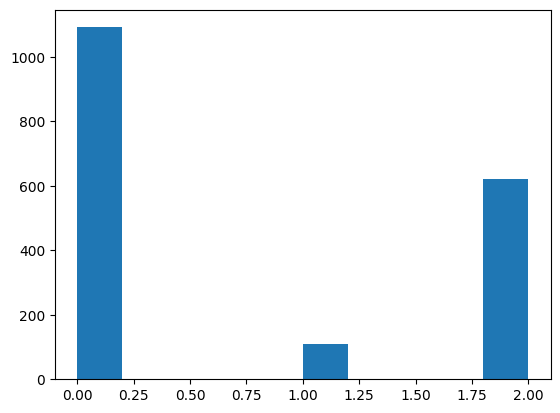

In [323]:
plt.hist(val_output)
plt.show()

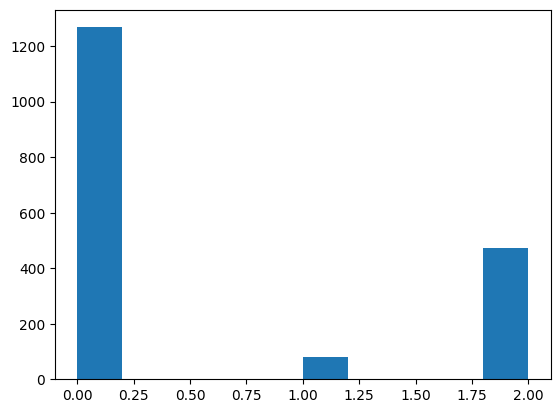

In [324]:
plt.hist(val_pred)
plt.show()

## 2. SMOTE 적용 후

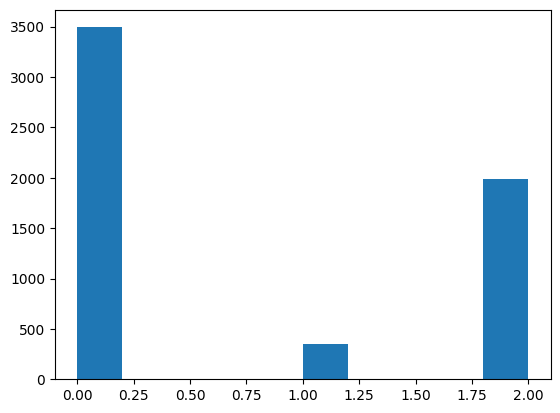

In [325]:
plt.hist(t_output)
plt.show()

In [326]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=32)

t_input, t_output = sm.fit_resample(t_input, t_output)

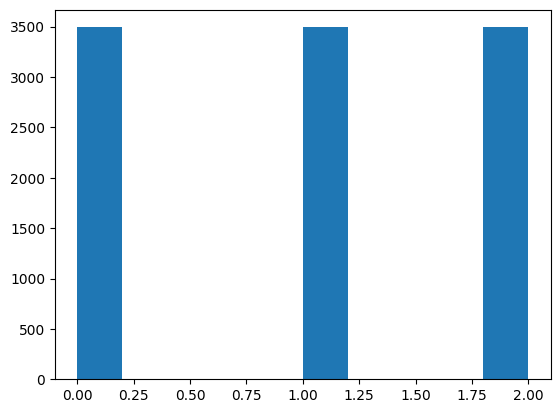

In [327]:
plt.hist(t_output)
plt.show()

In [328]:
### Light GBM ###
from lightgbm import LGBMClassifier

LGBM = LGBMClassifier()
evals = [(v_input, v_output)]
LGBM.fit(t_input, t_output, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a

[1]	valid_0's multi_logloss: 1.05031
[2]	valid_0's multi_logloss: 1.00938
[3]	valid_0's multi_logloss: 0.972824
[4]	valid_0's multi_logloss: 0.941578
[5]	valid_0's multi_logloss: 0.915929
[6]	valid_0's multi_logloss: 0.891269
[7]	valid_0's multi_logloss: 0.871676
[8]	valid_0's multi_logloss: 0.85351
[9]	valid_0's multi_logloss: 0.836038
[10]	valid_0's multi_logloss: 0.819527
[11]	valid_0's multi_logloss: 0.80263
[12]	valid_0's multi_logloss: 0.788233
[13]	valid_0's multi_logloss: 0.775014
[14]	valid_0's multi_logloss: 0.761681
[15]	valid_0's multi_logloss: 0.747683
[16]	valid_0's multi_logloss: 0.735243
[17]	valid_0's multi_logloss: 0.72487
[18]	valid_0's multi_logloss: 0.714978
[19]	valid_0's multi_logloss: 0.705395
[20]	valid_0's multi_logloss: 0.697004
[21]	valid_0's multi_logloss: 0.687761
[22]	valid_0's multi_logloss: 0.680624
[23]	valid_0's multi_logloss: 0.6724
[24]	valid_0's multi_logloss: 0.665746
[25]	valid_0's multi_logloss: 0.658214
[26]	valid_0's multi_logloss: 0.652283
[2

LGBMClassifier()

In [329]:
#  validation 성능
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# validation 데이터 예측
val_pred = LGBM.predict(val_input)

# 정확도 계산
accuracy = accuracy_score(val_output, val_pred)
print("Accuracy:", accuracy)

# 정밀도 계산
precision = precision_score(val_output, val_pred, average='macro')
print("Precision:", precision)

# 재현율 계산
recall = recall_score(val_output, val_pred, average='macro')
print("Recall:", recall)

# F1 스코어 계산
f1 = f1_score(val_output, val_pred, average='macro')
print("F1 Score:", f1)

Accuracy: 0.7652221612726275
Precision: 0.7395748360728578
Recall: 0.7510934047165931
F1 Score: 0.7451593756932641


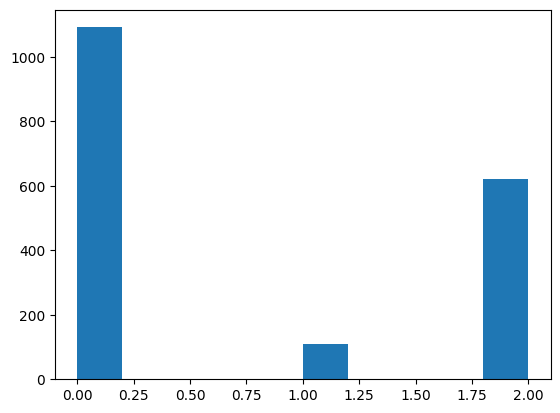

In [330]:
plt.hist(val_output)
plt.show()

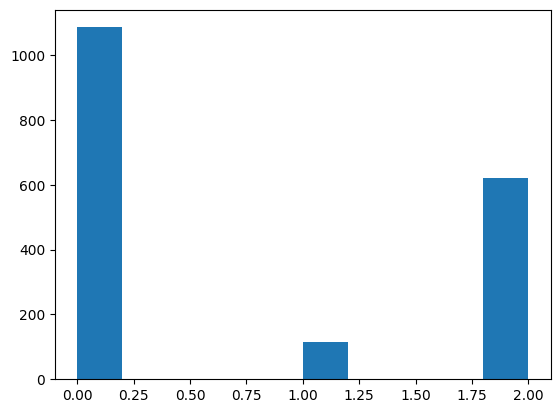

In [331]:
plt.hist(val_pred)
plt.show()

## 3. 클래스 가중치 설정

SMOTE를 사용해도 성능이 높아지지 않아서 SMOTE적용을 하지 않고 클래스 가중치를 설정하여 데이터 불균형을 해결하고자 하였습니다.

In [332]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_output, val_output = train_test_split(train_input_data, train_output_data, test_size=0.2, shuffle=True, stratify=train_output_data, random_state=42)

In [333]:
t_input, v_input, t_output, v_output = train_test_split(train_input, train_output, test_size=0.2, shuffle=True, stratify=train_output, random_state=42)

In [334]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_fit = scaler.fit(t_input)
t_input = scaler_fit.transform(t_input)
v_input = scaler_fit.transform(v_input)
val_input = scaler_fit.transform(val_input)

In [335]:
from collections import Counter

class_counts = dict(Counter(train_output['DIAG_NM']))
total_samples = sum(class_counts.values())
class_weights = {class_label: total_samples / count for class_label, count in class_counts.items()}
print(total_samples)
print(class_counts)
print(class_weights)

7289
{0: 4367, 2: 2482, 1: 440}
{0: 1.669109228303183, 2: 2.936744560838034, 1: 16.56590909090909}


In [336]:
### Light GBM ###
from lightgbm import LGBMClassifier

test_input = scaler_fit.transform(test_input)

LGBM = LGBMClassifier(class_weight=class_weights)
evals = [(test_input, test_output)]
LGBM.fit(train_input, train_output, early_stopping_rounds=200, eval_metric='logloss', eval_set=evals, verbose=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.c

[1]	valid_0's multi_logloss: 1.08451
[2]	valid_0's multi_logloss: 1.10755
[3]	valid_0's multi_logloss: 1.11751
[4]	valid_0's multi_logloss: 1.13594
[5]	valid_0's multi_logloss: 1.18453
[6]	valid_0's multi_logloss: 1.22713
[7]	valid_0's multi_logloss: 1.25941
[8]	valid_0's multi_logloss: 1.30986
[9]	valid_0's multi_logloss: 1.35813
[10]	valid_0's multi_logloss: 1.41009
[11]	valid_0's multi_logloss: 1.46687
[12]	valid_0's multi_logloss: 1.51886
[13]	valid_0's multi_logloss: 1.56689
[14]	valid_0's multi_logloss: 1.6314
[15]	valid_0's multi_logloss: 1.69323
[16]	valid_0's multi_logloss: 1.7483
[17]	valid_0's multi_logloss: 1.81431
[18]	valid_0's multi_logloss: 1.89365
[19]	valid_0's multi_logloss: 1.96546
[20]	valid_0's multi_logloss: 1.98082
[21]	valid_0's multi_logloss: 2.00191
[22]	valid_0's multi_logloss: 2.01446
[23]	valid_0's multi_logloss: 2.00844
[24]	valid_0's multi_logloss: 2.02411
[25]	valid_0's multi_logloss: 2.04828
[26]	valid_0's multi_logloss: 2.04461
[27]	valid_0's multi_lo

LGBMClassifier(class_weight={0: 1.669109228303183, 1: 16.56590909090909,
                             2: 2.936744560838034})

In [337]:
#  validation 성능
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# validation 데이터 예측
val_pred = LGBM.predict(val_input)

# 정확도 계산
accuracy = accuracy_score(val_output, val_pred)
print("Accuracy:", accuracy)

# 정밀도 계산
precision = precision_score(val_output, val_pred, average='macro')
print("Precision:", precision)

# 재현율 계산
recall = recall_score(val_output, val_pred, average='macro')
print("Recall:", recall)

# F1 스코어 계산
f1 = f1_score(val_output, val_pred, average='macro')
print("F1 Score:", f1)

Accuracy: 0.5990126165660998
Precision: 0.19967087218869994
Recall: 0.3333333333333333
F1 Score: 0.24974271012006863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


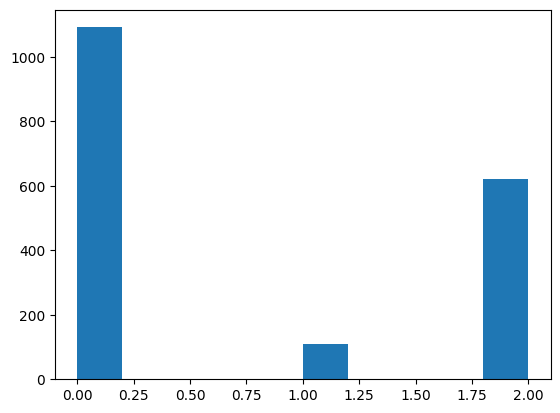

In [338]:
plt.hist(val_output)
plt.show()

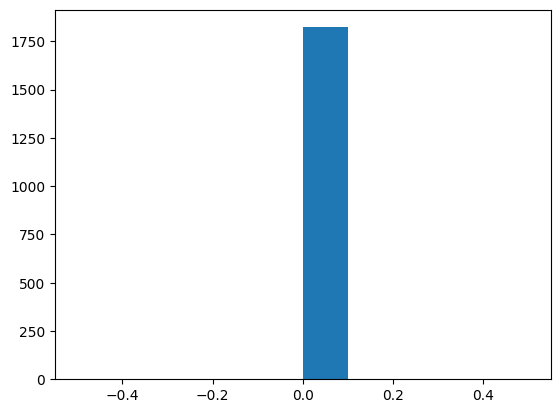

In [339]:
plt.hist(val_pred)
plt.show()

## 결론

* validation data로 확인해 보았을 때 MinMaxScaler만 적용한 경우가 Accuracy가 높고, F1 score가 조금 더 높다.
* 하지만 SMOTE를 적용한 경우 Recall이 더 좋다.
* 클래스 가중치를 사용한 경우는 성능이 좋지 않았다.
* 우리는 치매 환자일 가능성이 있는 사람들에게 경고를 알리는 앱을 개발해야 하므로 Recall이 Precision보다 더 중요하다. 따라서 SMOTE를 사용해 전처리를 한 모델을 사용하겠다.
